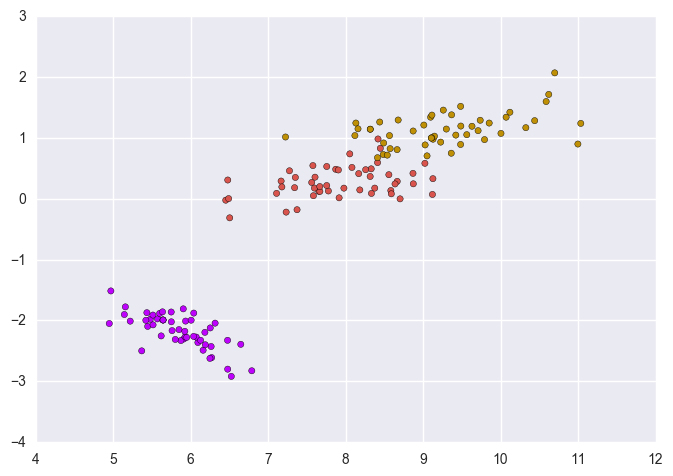

In [1]:
%matplotlib inline

# -*- coding: utf-8 -*-
import numpy as np

import tensorflow as tf
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
"""
TensorFlow Core programs can be divided into two discrete sections:
- Building the computational graph.
- Running the computational graph.
The graph needs to be executed from a session (tf.Session()) command to obtain
the output from its nodes.
"""
class PCA:
    def fit(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.X = tf.placeholder(self.dtype, shape=self.data.shape) #placeholder
            #where the data will be provided
            """
            s, u, v = tf.svd(tensor, full_matrices=False, compute_uv=True,
            name=None)
            - Args:
                - tensor: Tensor of shape [..., M, N]. Let P be the minimum of M
                and N.
                - full_matrices: If true, compute full-sized u and v. If false
                (the default), compute only the leading P singular vectors.
                Ignored if compute_uv is False.
                - compute_uv: If True then left and right singular vectors will
                be computed and returned in u and v, respectively. Otherwise,
                only the singular values will be computed, which can be
                significantly faster.
                - name: string, optional name of the operation.
            - Return:
                - s: Singular values. Shape is [..., P]. The values are sorted
                in reverse order of magnitude, so s[..., 0] is the largest value,
                s[..., 1] is the second largest, etc.
                - u: Left singular vectors. If full_matrices is False (default)
                then shape is [..., M, P]; if full_matrices is True then shape is
                [..., M, M]. Not returned if compute_uv is False.
                - v: Right singular vectors. If full_matrices is False (default)
                then shape is [..., N, P]. If full_matrices is True then shape is
                [..., N, N]. Not returned if compute_uv is False.
            """
            singular_values, u, _ = tf.svd(self.X) #Perform SVD
            # Create sigma matrix where the diagonal values will be
            # singular_values and the rest will be 0
            sigma = tf.diag(singular_values)

        with tf.Session(graph=self.graph) as session: #3 variables will be 
        # obtained
            self.u, self.singular_values, self.sigma =\
                session.run(
                    [u, singular_values, sigma],
                    feed_dict={self.X: self.data}
                )

    def reduce(self, keep_info=None):
        # Normalize singular values
        normalized_singular_values = self.singular_values / sum(self.singular_values)
        # Create the aggregated ladder of kept information per dimension. When
        # the aggregated is bigger that keep_info we'll keep that number of
        # dimensions
        ladder = np.cumsum(normalized_singular_values)
        # Get the first index which is above the given information threshold.
        # next(iterator) : Return the next item from the iterator.
        # enumerate(sequence) : Return an enumerate object. 
        index = next(idx for idx, value in enumerate(ladder) if value >= keep_info)\
            + 1
        n_dimensions = index # number of dimensions we will use

        with self.graph.as_default():
            # Cut out the relevant part from sigma
            sigma = tf.slice(self.sigma, [0, 0], [self.data.shape[1], n_dimensions])
            # PCA
            pca = tf.matmul(self.u, sigma)

        with tf.Session(graph=self.graph) as session:
            return session.run(pca, feed_dict={self.X: self.data})

    def __init__(self, data, target, dtype = tf.float32):
        self.data = data
        self.target = target
        self.dtype = dtype

if __name__ == "__main__":
    iris_dataset = datasets.load_iris(return_X_y=False)
    tf_pca = PCA(iris_dataset.data, iris_dataset.target)
    tf_pca.fit()
    pca = tf_pca.reduce(keep_info=0.9)

    color_mapping = {0: sns.xkcd_rgb['bright purple'],\
        1: sns.xkcd_rgb['pale red'], 2: sns.xkcd_rgb['ochre']}
    colors = list(map(lambda x: color_mapping[x], tf_pca.target))
    plt.scatter(pca[:, 0], pca[:, 1], c=colors)
    plt.show()